In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'figure.figsize':(15, 6)})

import matplotlib.pyplot as plt
import matplotlib.cm as cm


# 2 The Factors

Use the data found in ‘factor pricing data.xlsx’.

• FACTORS: Monthly excess return data for the overall equity market, r ̃MKT. The sheet also
contains data on five additional factors. All factor data is already provided as excess returns.2

1. Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.You now have three additional factors, so let’s compare there univariate statistics. 

• mean

• volatility

• Sharpe


In [2]:
factors = pd.read_excel(r'/Users/yasmineouattara/Desktop/FINM 367 - Portfolio and Risk Management/factor_pricing_data.xlsx',sheet_name = 'factors (excess returns)')
factors = factors.set_index('Date')

In [3]:
def summaryStats(df):
    
    summary = pd.DataFrame(index = df.columns)
    
    summary['Mean'] = df.mean()*12
    summary['Volatility'] = df.std()*np.sqrt(12)
    summary['Sharpe Ratio'] = summary['Mean']/summary['Volatility']    
        
    return summary

In [4]:
summaryStats(factors)

,Mean,Volatility,Sharpe Ratio
MKT,0.084562,0.157284,0.537641
SMB,0.011206,0.100525,0.111476
HML,0.025324,0.110162,0.229880
RMW,0.046525,0.083404,0.557824
CMA,0.032492,0.073379,0.442794
UMD,0.060925,0.155507,0.391780


In [5]:
# Before 1980
summaryStats(factors[:'1980'])

,Mean,Volatility,Sharpe Ratio
MKT,0.2029,0.203717,0.995990
SMB,0.0537,0.108821,0.493472
HML,-0.1987,0.117754,-1.687412
RMW,0.1078,0.073037,1.475957
CMA,-0.0977,0.076936,-1.269882
UMD,0.3078,0.234594,1.312054


In [6]:
# 1981 - 2001
summaryStats(factors['1981':'2001'])

,Mean,Volatility,Sharpe Ratio
MKT,0.077257,0.157396,0.490847
SMB,0.001429,0.109605,0.013034
HML,0.063776,0.111183,0.573612
RMW,0.046914,0.091606,0.512130
CMA,0.053157,0.077355,0.687185
UMD,0.101686,0.145105,0.700775


In [7]:
#2002-2023
summaryStats(factors['2002':])

,Mean,Volatility,Sharpe Ratio
MKT,0.086187,0.155313,0.554923
SMB,0.018751,0.090739,0.206642
HML,-0.001710,0.107517,-0.015901
RMW,0.043307,0.075282,0.575261
CMA,0.018417,0.068581,0.268543
UMD,0.009827,0.159709,0.061531


### 2. Based on the factor statistics above, answer the following.

(a) Does each factor have a positive risk premium (positive expected excess return)? 

In general all factors show a positive risk premium, but when looking at the breackdown HML and CMA had a negative risk premium before 1980 and HML also had a negative mean between 2002 and 2023

(b) How have the factors performed since the time of the case, (2015-present)?

The factors with the highest mean return are MKT first then RMW. All the others have positive mean return except HML.

### 3. Report the correlation matrix across the six factors.

(a) Does the construction method succeed in keeping correlations small?

The only high correlation is the the correlation between HML and SMB. Otherwise the others appear to be quite low. 

(b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

Yes given the high correlation in HML and CMA. 


<AxesSubplot:>

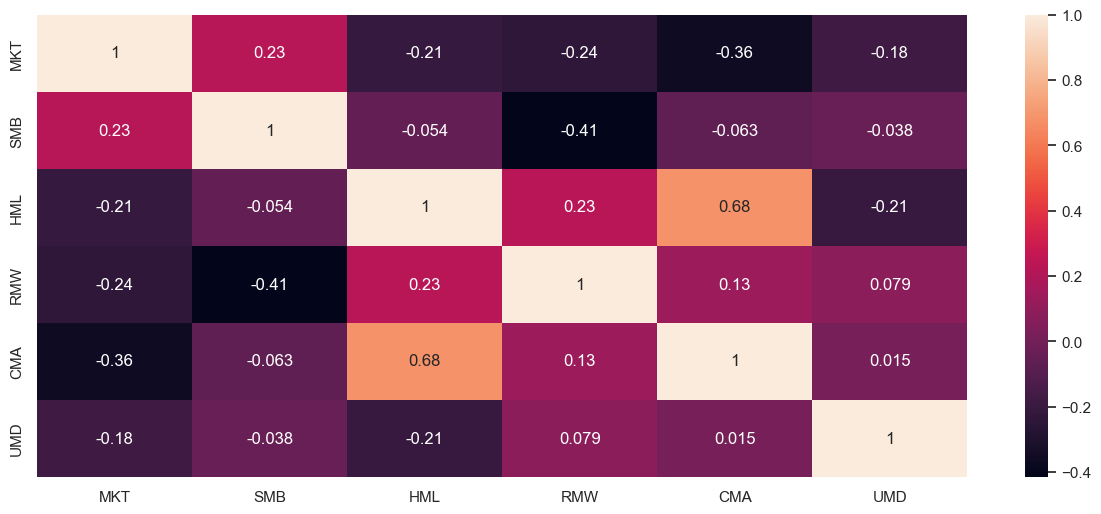

In [8]:
corr = factors.corr()
sns.heatmap(corr,annot=True)

### 4. Report the tangency weights for a portfolio of these 6 factors.

(a) Which factors seem most important? And Least?

The most important factors appear to be CMA, RMW and MKT and HML will be the least important. 

(b) Are the factors with low mean returns still useful?

SMB and HML have low mean and low weight. I woudl consider SMB still usefull but HML is redundant due to the high correlation with CMA.

(c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?


We can observe the low mean return of HML.

In [9]:
def computeTangencyPortfolio(df):
    """ Assuming monthly input data and annualized outputs"""

    mean = df.mean()*12
    sigma = df.std() * np.sqrt(12)
    cov = df.cov()*12
    cov_inv = np.linalg.inv(cov)
    
    w_t = pd.Series(cov_inv@mean,index=mean.index,name="TangencyPortfolio")
    w_t = w_t/sum(w_t)
    
    tangencyMean = w_t@mean
    tangencyVol = np.sqrt(w_t.T@cov@w_t)
    tangencySharpe = tangencyMean/tangencyVol
    
    return w_t,tangencyMean,tangencyVol,tangencySharpe

tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors)

In [10]:
print("Weights of Tangency Portfolio:")
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False)

Weights of Tangency Portfolio:


,Tangency Weights
CMA,0.369283
RMW,0.307353
MKT,0.203875
UMD,0.093818
SMB,0.087446
HML,-0.061776


In [11]:
tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors[['MKT','SMB','HML','UMD']])
print("Weights of Tangency Portfolio:")
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False)

Weights of Tangency Portfolio:


,Tangency Weights
MKT,0.356440
HML,0.348903
UMD,0.300861
SMB,-0.006204


In [12]:
pd.concat([summaryStats(factors)['Mean'],tangencyWt],axis =1).dropna().sort_values('Mean')

,Mean,TangencyPortfolio
SMB,0.011206,-0.006204
HML,0.025324,0.348903
UMD,0.060925,0.300861
MKT,0.084562,0.356440


# 3 Testing Modern LPMs

Consider the following factor models:

• CAPM: MKT

• Fama-French 3F: MKT, SMB, HML

• Fama-French 5F: MKT, SMB, HML, RMW, CMA • AQR: MKT, HML, RMW, UMD


So you are running that regression n times, once for each security, r ̃ . Data

• PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. i
Denote these as r ̃ , for n = 1, . . . , 49.

• You do NOT need the risk-free rate data. It is provided only for completeness. The other two
tabs are already in terms of excess returns.

### 1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)
(a) For each regression, report the estimated α and r-squared.

(b) Calculate the mean-absolute-error of the estimated alphas, (one for each security, r ̃ .)

If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

Alpha estimates should be small. 






In [13]:
portfolios = pd.read_excel('factor_pricing_data.xlsx',sheet_name='portfolios (excess returns)',index_col='Date')

def linearRegression(seriesY,seriesX):
    
    mean =seriesY.mean()*12
    sharpe = mean/(seriesY.std()*(12**0.5))
    model = sm.OLS(seriesY,sm.add_constant(seriesX)).fit()
    rsq = model.rsquared
    
    beta = pd.DataFrame(index= [seriesY.name])
    
    for i,x in enumerate(seriesX):
         beta[x] = model.params[i+1]
    
    betaCols = [i+'Beta' for i in seriesX]
    beta = beta.rename(columns = dict(zip(beta.columns,betaCols)))
    
    treynor = mean/beta[beta.columns[0]]
    alpha = model.params[0]*12
    information = alpha/(model.resid.std()*np.sqrt(12))
    
    RegressionStats = pd.DataFrame({'Mean Return':mean,'Sharpe Ratio':sharpe,'R Squared':rsq,\
                         'Alpha':alpha, 'Information Ratio':information, 'Treynor':treynor},index= [seriesY.name])
    
    return pd.concat([RegressionStats,beta], axis =1)

In [14]:
aqr = factors[['MKT', 'HML', 'RMW', 'UMD']]

In [15]:
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],aqr)
    frames.append(p) 
AQRRegression = pd.concat(frames)
AQRRegression.T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Mean Return,0.089693,0.099669,0.108840,0.119426,0.132925,0.062946,0.118245,0.074122,0.081545,0.098083,...,0.092398,0.090785,0.085521,0.111818,0.103863,0.088988,0.095899,0.048103,0.110258,0.050820
Sharpe Ratio,0.412541,0.660014,0.490980,0.700661,0.592263,0.252209,0.446060,0.357971,0.529226,0.437351,...,0.462944,0.452969,0.473165,0.596456,0.569968,0.413863,0.526738,0.192725,0.493620,0.239526
R Squared,0.341333,0.471088,0.307178,0.426698,0.272555,0.510315,0.617319,0.689702,0.560258,0.631763,...,0.586154,0.707433,0.756767,0.683464,0.643047,0.772044,0.685298,0.603615,0.812962,0.595904
Alpha,0.009491,0.011434,0.019555,0.024178,0.035317,-0.032189,0.031788,-0.030329,-0.005510,-0.011724,...,0.002115,-0.017072,-0.013517,0.019527,0.002487,-0.022979,-0.008563,-0.056717,0.018242,-0.045176
Information Ratio,0.053788,0.104111,0.105981,0.187339,0.184497,-0.184306,0.193848,-0.262943,-0.053928,-0.086150,...,0.016476,-0.157477,-0.151638,0.185137,0.022844,-0.223835,-0.083839,-0.360927,0.188842,-0.334950
Treynor,0.107052,0.146377,0.138704,0.165106,0.180305,0.056362,0.094682,0.066563,0.108322,0.087683,...,0.094565,0.083035,0.082898,0.113938,0.109533,0.076764,0.097882,0.040084,0.088997,0.047921
MKTBeta,0.837838,0.680903,0.784688,0.723330,0.737220,1.116824,1.248868,1.113566,0.752802,1.118614,...,0.977081,1.093328,1.031640,0.981389,0.948235,1.159250,0.979743,1.200074,1.238895,1.060498
HMLBeta,0.178699,0.169841,0.206106,0.025183,0.249344,-0.035336,0.000177,0.265474,0.000889,0.049475,...,0.116515,0.189071,0.099153,-0.140767,0.080657,0.721895,0.479804,0.490751,0.327216,0.087573
RMWBeta,-0.006405,0.507359,0.494736,0.600586,0.657434,0.230797,-0.109524,0.177919,0.485108,0.564987,...,0.255496,0.352329,0.185132,0.347550,0.500334,0.087560,0.222779,0.062269,-0.401302,0.117101
UMDBeta,0.084119,0.045146,-0.087111,0.090319,-0.026824,-0.150169,-0.230768,-0.077390,0.013206,-0.202276,...,-0.117838,-0.094835,0.011102,-0.054203,-0.067775,-0.138145,-0.014815,-0.196719,-0.038805,-0.022131


In [16]:
AQR_MAE = round(abs(AQRRegression['Alpha']).mean(),6)
print(f'Mean Absolute Error for AQR factors: {AQR_MAE}')

Mean Absolute Error for AQR factors: 0.022995


### 2. Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [17]:
ff3 = factors[['MKT', 'SMB', 'HML']]

frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff3)
    frames.append(p) 
FF3Regression = pd.concat(frames)

FF3_MAE = round(abs(FF3Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-3 Factor Model: {FF3_MAE}')

Mean Absolute Error for FF-3 Factor Model: 0.0242


In [18]:
ff5 = factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff5)
    frames.append(p) 
FF5Regression = pd.concat(frames)
FF5_MAE = abs(FF3Regression['Alpha']).mean()


FF5_MAE = round(abs(FF5Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-5 Factor Model: {FF5_MAE}')

Mean Absolute Error for FF-5 Factor Model: 0.031272


In [19]:
MAE_TS = pd.DataFrame({'MAE':[AQR_MAE,FF3_MAE,FF5_MAE]}, index = ["AQR","FF-3","FF-5"])
MAE_TS

,MAE
AQR,0.022995
FF-3,0.024200
FF-5,0.031272


### 3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?


Momentum can be important which can be seen by the Low MAE.



### 4. This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?


The R squared are all very close and all show a moderate low explainability of the excess returns by the factor models. 

In [20]:
AQR_RSq = AQRRegression['R Squared'].mean()
FF3_RSq = FF3Regression['R Squared'].mean()
FF5_RSq = FF5Regression['R Squared'].mean()


Average_R_Squared = pd.Series({'AQR':AQR_RSq,'FF3':FF3_RSq,'FF5':FF5_RSq})
Average_R_Squared.to_frame("Average R Squared")

,Average R Squared
AQR,0.577081
FF3,0.572516
FF5,0.597519


### 5. We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

(a) Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

(b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the υi.) How do they compare to the MAE of the time-series alphas?

In [21]:
time_series_premia = (factors.mean()*12).to_frame('Time Series Premia')
time_series_premia.index = [x+"Beta" for x in time_series_premia.index]


In [22]:
y = AQRRegression['Mean Return']
x = AQRRegression[['MKTBeta','HMLBeta','RMWBeta','UMDBeta']]
AQRRegressionCS = sm.OLS(y,x,missing='drop').fit()
AQR_CS_MAE = abs(AQRRegressionCS.resid).mean()
AQR_CS_premia = AQRRegressionCS.params.to_frame("AQR CS Premia")


In [23]:
y = FF3Regression['Mean Return']
x = FF3Regression[['MKTBeta','SMBBeta','HMLBeta']]
FF3RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF3_CS_MAE = abs(FF3RegressionCS.resid).mean()
FF3_CS_Premia = FF3RegressionCS.params.to_frame("FF3 CS Premia")


In [24]:
y = FF5Regression['Mean Return']
x = FF5Regression[['MKTBeta','SMBBeta','HMLBeta','RMWBeta','CMABeta']]
FF5RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF5_CS_MAE = abs(FF5RegressionCS.resid).mean()
FF5_CS_Premia = FF5RegressionCS.params.to_frame("FF5 CS Premia")


In [25]:
pd.concat([time_series_premia,AQR_CS_premia,FF3_CS_Premia,FF5_CS_Premia],axis = 1).fillna('')

,Time Series Premia,AQR CS Premia,FF3 CS Premia,FF5 CS Premia
MKTBeta,0.084562,0.087644,0.101569,0.095697
SMBBeta,0.011206,,-0.064615,-0.057674
HMLBeta,0.025324,-0.039757,-0.017476,-0.033504
RMWBeta,0.046525,0.044399,,0.035899
CMABeta,0.032492,,,-0.015156
UMDBeta,0.060925,0.053375,,


In [26]:
MAE_CS = pd.Series([AQR_CS_MAE,FF3_CS_MAE, FF5_CS_MAE], index = MAE_TS.index)
MAE = pd.concat([MAE_TS,MAE_CS],axis = 1)
MAE.columns = ['Time Series MAE', 'Cross Section MAE']
MAE

,Time Series MAE,Cross Section MAE
AQR,0.022995,0.016395
FF-3,0.024200,0.015031
FF-5,0.031272,0.012982
